In [ ]:
!pip install datasets==2.14.5
!pip install kmedoids==0.5.2

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
# import kaggle
from datasets import load_dataset
import copy
import torch
from sklearn.cluster import KMeans
import kmedoids
from sklearn.metrics import pairwise_distances

import os
import matplotlib.pyplot as plt
import cv2
from difflib import get_close_matches

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from utils import *

In [ ]:
higging_face_df = load_dataset("Grandediw/clash-royale-battle")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
df = higging_face_df['train'].to_pandas()
all_card_ids = set()
for i in range(8):
  all_card_ids = all_card_ids.union(list(df[f"winner.card{i+1}.id"].unique()))
  all_card_ids = all_card_ids.union(list(df[f"loser.card{i+1}.id"].unique()))
all_card_ids = sorted(list(all_card_ids))

In [ ]:
remove_cols = [
 'Unnamed: 0',
 'battleTime',
#  'arena.id',      # Filter
#  'gameMode.id',   # Filter
 # 'average.startingTrophies',  # Filter
 'winner.tag',
#  'winner.startingTrophies',
 'winner.trophyChange',
 'winner.crowns',
 'winner.kingTowerHitPoints',#
 'winner.princessTowersHitPoints',
 'winner.clan.tag',
 'winner.clan.badgeId',
 'loser.tag',
#  'loser.startingTrophies',
 'loser.trophyChange',
 'loser.crowns',
 'loser.kingTowerHitPoints',
 'loser.clan.tag',
 'loser.clan.badgeId', #
 'loser.princessTowersHitPoints',
 'tournamentTag',
 'winner.card1.id',
#  'winner.card1.level',
 'winner.card2.id',
#  'winner.card2.level',
 'winner.card3.id',
#  'winner.card3.level',
 'winner.card4.id',
#  'winner.card4.level',
 'winner.card5.id',
#  'winner.card5.level',
 'winner.card6.id',
#  'winner.card6.level',
 'winner.card7.id',
#  'winner.card7.level',
 'winner.card8.id',
#  'winner.card8.level',
#  'winner.cards.list',
 'winner.totalcard.level',  # TODO
#  'winner.troop.count',
#  'winner.structure.count',
#  'winner.spell.count',
 'winner.common.count',
 'winner.rare.count',
 'winner.epic.count',
 'winner.legendary.count',
#  'winner.elixir.average',
 'loser.card1.id',
#  'loser.card1.level',
 'loser.card2.id',
#  'loser.card2.level',
 'loser.card3.id',
#  'loser.card3.level',
 'loser.card4.id',
#  'loser.card4.level',
 'loser.card5.id',
#  'loser.card5.level',
 'loser.card6.id',
#  'loser.card6.level',
 'loser.card7.id',
#  'loser.card7.level',
 'loser.card8.id',
#  'loser.card8.level',
#  'loser.cards.list',
 'loser.totalcard.level',   # TODO
#  'loser.troop.count',
#  'loser.structure.count',
#  'loser.spell.count',
 'loser.common.count',
 'loser.rare.count',
 'loser.epic.count',
 'loser.legendary.count',
#  'loser.elixir.average'
 ]

df.drop(remove_cols, axis=1, inplace=True)
df.drop(df[df['arena.id'] != 54000050.0].index, inplace=True)
df_mode1 = df.drop(df[df['gameMode.id'] != 72000006.0].index, inplace=False)
df_mode2 = df.drop(df[df['gameMode.id'] != 72000201.0].index, inplace=False)
df_mode1.drop(["arena.id", "gameMode.id"], axis=1, inplace=True)
df_mode2.drop(["arena.id", "gameMode.id"], axis=1, inplace=True)

for i in range(8):
  df_mode1.drop(df_mode1[df_mode1[f"loser.card{i+1}.level"] != 13].index, inplace=True)
  df_mode1.drop(df_mode1[df_mode1[f"winner.card{i+1}.level"] != 13].index, inplace=True)
  df_mode2.drop(df_mode2[df_mode2[f"loser.card{i+1}.level"] != 13].index, inplace=True)
  df_mode2.drop(df_mode2[df_mode2[f"winner.card{i+1}.level"] != 13].index, inplace=True)
  df_mode1.drop([f"loser.card{i+1}.level"], axis=1, inplace=True)
  df_mode1.drop([f"winner.card{i+1}.level"], axis=1, inplace=True)
  df_mode2.drop([f"loser.card{i+1}.level"], axis=1, inplace=True)
  df_mode2.drop([f"winner.card{i+1}.level"], axis=1, inplace=True)

In [ ]:
df_mode1 = df_mode1.sort_values(by='average.startingTrophies', ascending=False).head(10000)
df_mode1

,average.startingTrophies,winner.startingTrophies,loser.startingTrophies,winner.cards.list,winner.troop.count,winner.structure.count,winner.spell.count,winner.elixir.average,loser.cards.list,loser.troop.count,loser.structure.count,loser.spell.count,loser.elixir.average
305194,7066.5,7005.0,7128.0,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250,"[26000000, 26000010, 26000023, 27000006, 27000...",3,2,3,3.500
1624463,7030.0,7035.0,7025.0,"[26000000, 26000010, 26000023, 27000006, 27000...",3,2,3,3.500,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250
187746,7023.0,7018.0,7028.0,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250,"[26000009, 26000013, 26000015, 26000035, 26000...",6,0,2,4.375
366652,7021.5,6983.0,7060.0,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250,"[26000003, 26000016, 26000027, 26000032, 26000...",6,0,2,3.750
1505223,7018.5,7031.0,7006.0,"[26000006, 26000011, 26000032, 26000039, 26000...",5,1,2,3.625,"[26000005, 26000006, 26000008, 26000022, 26000...",6,0,2,4.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619294,6340.0,6344.0,6336.0,"[26000000, 26000001, 26000004, 26000006, 26000...",6,0,2,4.000,"[26000000, 26000019, 26000032, 26000049, 26000...",5,1,2,2.500
1503923,6340.0,6352.0,6328.0,"[26000000, 26000012, 26000026, 26000040, 26000...",5,1,2,3.125,"[26000009, 26000015, 26000023, 26000048, 27000...",4,1,3,4.250
474275,6340.0,6346.0,6334.0,"[26000000, 26000014, 26000023, 26000054, 27000...",4,2,2,4.000,"[26000006, 26000010, 26000014, 26000032, 26000...",5,1,2,2.875
1710720,6340.0,6341.0,6339.0,"[26000003, 26000012, 26000014, 26000018, 26000...",6,0,2,3.625,"[26000000, 26000019, 26000032, 26000049, 26000...",5,1,2,2.625


In [ ]:
cards1 = pd.read_csv("/content/Wincons.csv")
cards2 = pd.read_csv("/content/CardMasterListSeason18_12082020.csv")
id1 = cards1["card_id"]
names1 = cards1["card_name"]
id2 = cards2["team.card1.id"]
names2 = cards2["team.card1.name"]
id_to_name = {}
for i in range(len(id1)):
    id_to_name[id1[i].item()] = names1[i]
for i in range(len(id2)):
    id_to_name[id2[i].item()] = names2[i]
total_num_cards = len(id_to_name)
id_to_id = {}
id_to_id_reversed = {}
for i, idd in enumerate(id_to_name.keys()):
    id_to_id[idd] = i
    id_to_id_reversed[i] = idd

matches = getMatches(df_mode1, total_num_cards, id_to_id)

In [ ]:
decks = []
wins = []
for match_id in range(0, len(matches)):
    match = matches[match_id]
    combined_deck = np.concatenate((match[0].winner_info["cards"], match[0].loser_info["cards"]))
    decks.append(combined_deck)
    wins.append(match[1])
decks = np.array(decks)
wins = np.array(wins)



In [ ]:
matches[0]

[<utils.Match at 0x7efb697f8fd0>, 1]

In [ ]:
matches[1]

[<utils.Match at 0x7efd1848a410>, 0]

In [ ]:
print(decks[0])
print(decks.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
(20000, 206)


In [ ]:
decks[0][:103]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.])

In [ ]:
decks[0][103:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0.])

In [ ]:
# metric = "l1"
# num_clusters = 40
# clustering_result_folder = f"kmedoids_{metric}_{num_clusters}"
# distance_matrix = pairwise_distances(decks, metric=metric)
# km = kmedoids.KMedoids(num_clusters, method='fasterpam')
# km.fit(distance_matrix)
# labels_ = km.labels_
# medoid_indices_ = km.medoid_indices_

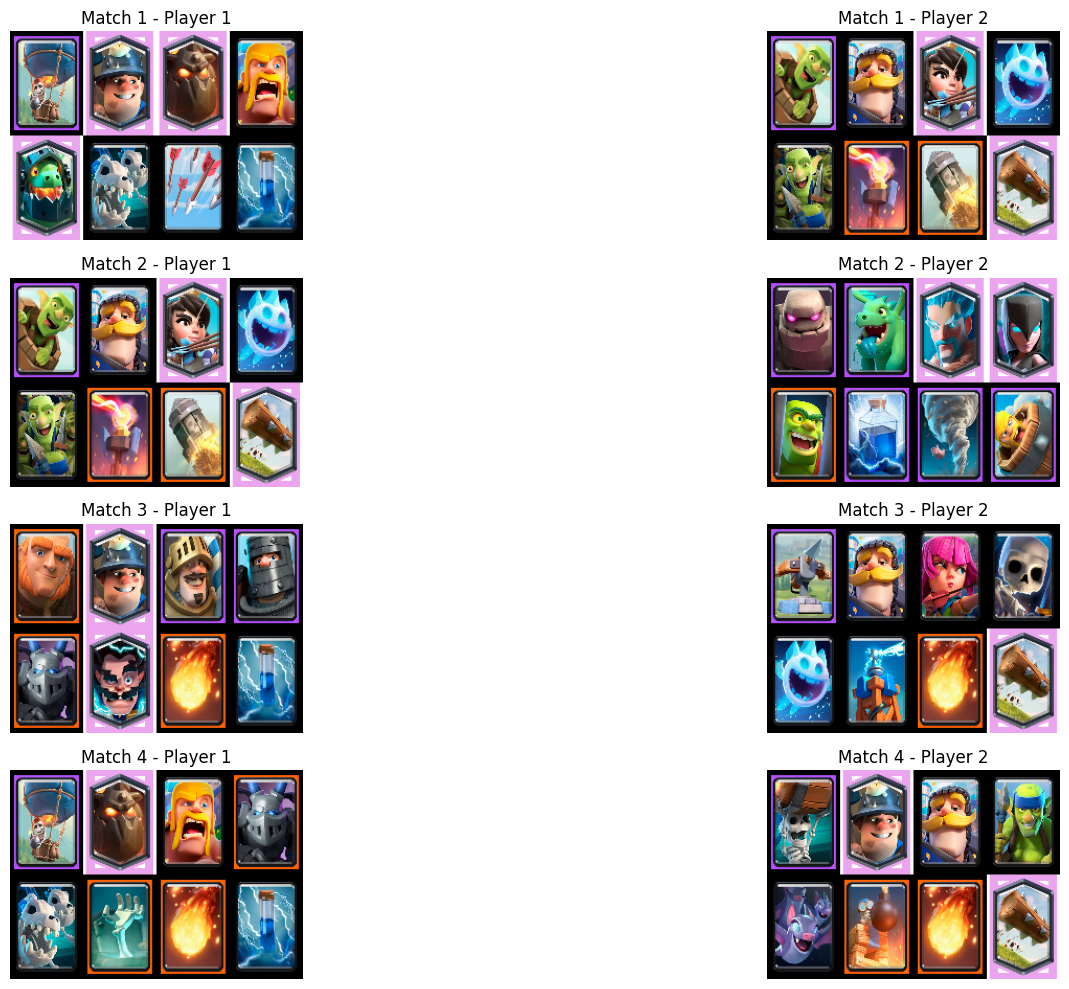

In [ ]:
folder_path = "/content/CR_Pic"

def draw_decks(all_decks, folder_path, x, y):
    fig, axes = plt.subplots(x, y, figsize=(20, 10))

    for idx, ax in enumerate(axes.flat):
        if idx >= len(all_decks):
            break

        card_names = all_decks[idx]  # Extract single deck
        images = []

        for name in card_names:
            image_path = os.path.join(folder_path, name) + ".png"
            img = cv2.imread(image_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = np.ones((100, 70, 3), dtype=np.uint8) * 255  # White placeholder
            images.append(img)

        # Ensure exactly 8 images per deck
        images += [np.ones((100, 70, 3), dtype=np.uint8) * 255] * (8 - len(images))

        # Create a 2-row layout (4 cards per row)
        row1 = np.hstack([cv2.resize(img, (70, 100)) for img in images[:4]])
        row2 = np.hstack([cv2.resize(img, (70, 100)) for img in images[4:]])
        deck_img = np.vstack([row1, row2])

        # Determine match number and player
        match_number = (idx // 2) + 1  # Each match has 2 decks
        player_number = "Player 1" if idx % 2 == 0 else "Player 2"

        ax.imshow(deck_img)
        ax.set_title(f"Match {match_number} - {player_number}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()



# Prepare all decks in the format that draw_decks expects
formatted_decks = []
for idx in range(num_clusters):
    # Extract first player's deck (first 103)
    ids_p1 = np.nonzero(decks[medoid_indices_[idx]][:103])[0]
    card_names_p1 = [id_to_name[id_to_id_reversed[idd]] for idd in ids_p1 if id_to_id_reversed[idd] in id_to_name]

    # Extract second player's deck (last 103)
    ids_p2 = np.nonzero(decks[medoid_indices_[idx]][103:])[0]
    card_names_p2 = [id_to_name[id_to_id_reversed[idd]] for idd in ids_p2 if id_to_id_reversed[idd] in id_to_name]

    # Append separately to match draw_decks input format
    formatted_decks.append(card_names_p1)  # Deck 1 (P1)
    formatted_decks.append(card_names_p2)  # Deck 2 (P2)

# Now call draw_decks with correctly formatted decks
draw_decks(formatted_decks, folder_path, 4, 2)


In [ ]:
from sklearn.manifold import TSNE

# Define new dataset with (P1 + P2 + match outcome)
decks_combined = np.hstack((decks[:, :103], decks[:, 103:], wins.reshape(-1, 1)))  # Shape: (10000, 207)

In [ ]:

from sklearn.metrics import pairwise_distances


# Define clustering parameters
metric = "l1"
num_clusters = 250

    # Compute distance matrix based on new full match data
distance_matrix = pairwise_distances(decks_combined, metric=metric)

    # Apply K-Medoids clustering
km = kmedoids.KMedoids(num_clusters, method='fasterpam')
km.fit(distance_matrix)

    # Save results
labels_ = km.labels_
medoid_indices_ = km.medoid_indices_
print("Computed and saved kmedoids result.")

# ✅ Fix: Compute Win Rate Per Cluster Using Matches, Not Players
num_wins_per_cluster = np.zeros(num_clusters)
num_matches_per_cluster = np.zeros(num_clusters)

# Iterate over every match (not individual player entries)
for match_id in range(0, len(labels_), 2):  # Every two rows represent one match
    cluster_id = labels_[match_id]  # Use the first player's cluster ID
    win_status = wins[match_id]  # Only use the winner's recorded outcome

    num_wins_per_cluster[cluster_id] += win_status
    num_matches_per_cluster[cluster_id] += 1

# Avoid division by zero
num_wins_per_cluster /= np.maximum(num_matches_per_cluster, 1)

print("Win rate per cluster (Fixed):")
print(num_wins_per_cluster)

# Check cluster similarity using distance threshold
similar_clusters = (pairwise_distances(decks_combined[medoid_indices_], metric=metric) + np.eye(num_clusters) * 1000 < 4).sum()
print("Number of similar clusters:", similar_clusters)


Computed and saved kmedoids result.
Win rate per cluster (Fixed):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of similar clusters: 0


In [ ]:
km.labels_

array([155,  37,  37, ...,  72, 223,  88], dtype=uint64)

In [ ]:
num_wins_per_cluster = np.zeros(num_clusters)
for cluster_id in range(num_clusters):
    num_wins_per_cluster[cluster_id] = ((km.labels_ == cluster_id) * wins).sum() / (km.labels_ == cluster_id).sum()
print(num_wins_per_cluster)

[0.42372881 0.40963855 0.3880597  0.36708861 0.32786885 0.30666667
 0.578125   0.6835443  0.52083333 0.6969697  0.33333333 0.57894737
 0.60493827 0.39285714 0.2962963  0.43529412 0.67123288 0.6
 0.36538462 0.63492063 0.41538462 0.33333333 0.31666667 0.61290323
 0.4        0.26851852 0.70114943 0.3943662  0.3255814  0.44444444
 0.375      0.36734694 0.4025974  0.67816092 0.54716981 0.74666667
 0.39455782 0.54411765 0.34831461 0.57627119 0.24615385 0.79452055
 0.60784314 0.65686275 0.36111111 0.44936709 0.55882353 0.31506849
 0.56923077 0.27710843 0.59322034 0.35211268 0.22727273 0.35135135
 0.375      0.71428571 0.40384615 0.71052632 0.75531915 0.5625
 0.36111111 0.61445783 0.63636364 0.74647887 0.34736842 0.63513514
 0.31168831 0.35897436 0.6        0.30232558 0.41       0.43529412
 0.26804124 0.27272727 0.54929577 0.31884058 0.60810811 0.6
 0.61538462 0.21428571 0.68131868 0.69135802 0.28571429 0.59016393
 0.58139535 0.42222222 0.67647059 0.42592593 0.65116279 0.32835821
 0.375      0

In [ ]:
pred = np.zeros(len(km.labels_))
for cluster_id in range(num_clusters):
    pred += (km.labels_ == cluster_id) * (num_wins_per_cluster[cluster_id] > 0.5)
print(np.mean(pred == wins))

0.63785


In [ ]:
km.labels_.shape

(20000,)

In [ ]:
num_wins_per_cluster.shape

(250,)

Loaded tSNE result from file.


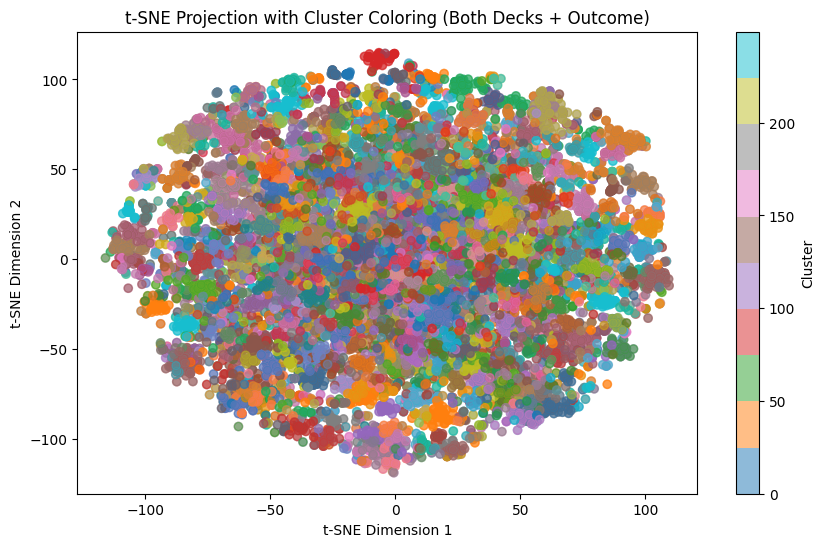

In [ ]:

# Check if t-SNE results exist, otherwise compute
tsne_result_path = clustering_result_folder + "/X_embedded.npy"
if os.path.exists(tsne_result_path):
    X_embedded = np.load(tsne_result_path)
    print("Loaded tSNE result from file.")
else:
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_embedded = tsne.fit_transform(decks_combined)  # Use full match data (20000, 206)
    os.makedirs(clustering_result_folder, exist_ok=True)
    np.save(tsne_result_path, X_embedded)
    print("Computed and saved t-SNE result.")

# ✅ Draw Scatter Plot of t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_, cmap='tab10', alpha=0.5)
plt.title("t-SNE Projection with Cluster Coloring (Both Decks + Outcome)")
plt.colorbar(label="Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [ ]:
class MatchSampler(torch.utils.data.Dataset):
    def __init__(self, matches):
        self.matches = matches

    def __len__(self):
        return len(self.matches)

    def __getitem__(self, idx):
        match = self.matches[idx][0]
        return_dic = {
            "my_cards" : match.winner_info["cards"],
            "my_features" : np.array([match.winner_info["troop_count"], match.winner_info["structure_count"], match.winner_info["spell_count"], match.winner_info["elixir_average"]]),
            "my_Trophies" : match.winner_info["Trophies"],
            "my_troop_count" : match.winner_info["troop_count"],
            "my_structure_count" : match.winner_info["structure_count"],
            "my_spell_count" : match.winner_info["spell_count"],
            "my_elixir_average" : match.winner_info["elixir_average"],

            "opponent_cards" : match.loser_info["cards"],
            "opponent_features" : np.array([match.loser_info["troop_count"], match.loser_info["structure_count"], match.loser_info["spell_count"], match.loser_info["elixir_average"]]),
            "opponent_Trophies" : match.loser_info["Trophies"],
            "opponent_troop_count" : match.loser_info["troop_count"],
            "opponent_structure_count" : match.loser_info["structure_count"],
            "opponent_spell_count" : match.loser_info["spell_count"],
            "opponent_elixir_average" : match.loser_info["elixir_average"],

            "labels" : self.matches[idx][1]
        }

        return return_dic

In [ ]:
dataset_sampler[0]

In [ ]:
batch_size = 100

dataset_sampler = MatchSampler(matches)

train_size = int(0.8 * len(dataset_sampler))
test_size = len(dataset_sampler) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_sampler, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class PredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers):
        super(PredModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers

        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, deck1, deck2, feature1, feature2):
        # x = torch.cat([feature1, feature2], axis=-1)
        x = torch.cat([deck1, deck2], axis=-1)
        y = self.input_layer(x)
        for layer in self.hidden_layers:
            y = F.relu(layer(y))
        y = self.output_layer(y)

        return F.softmax(y)

In [ ]:
def train(model, num_epochs, lr, train_dataloader, test_dataloader, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    eval_acc = []

    model = model.to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        model.train()

        num_data_for_test = 10
        for i, data in enumerate(train_dataloader):
            if i > num_data_for_test:
                continue
            my_cards = torch.tensor(data["my_cards"]).float().to(device)
            opponent_cards = torch.tensor(data["opponent_cards"]).float().to(device)
            my_features = torch.tensor(data["my_features"]).float().to(device)
            opponent_features = torch.tensor(data["opponent_features"]).float().to(device)
            labels = torch.tensor(data["labels"]).to(device)

            optimizer.zero_grad()
            ypred = model(my_cards, opponent_cards, my_features, opponent_features)

            loss = criterion(ypred, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            predictions = torch.argmax(ypred, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / len(train_dataloader)
        accuracy = 100 * correct / total

        train_loss.append(avg_loss)
        train_acc.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        if (epoch + 1) % 2 == 0:
            model.eval()
            eval_correct = 0
            eval_total = 0

            with torch.no_grad():
                for data in test_dataloader:
                    my_cards = torch.tensor(data["my_cards"]).float().to(device)
                    opponent_cards = torch.tensor(data["opponent_cards"]).float().to(device)
                    my_features = torch.tensor(data["my_features"]).float().to(device)
                    opponent_features = torch.tensor(data["opponent_features"]).float().to(device)
                    labels = torch.tensor(data["labels"]).to(device)

                    ypred = model(my_cards, opponent_cards, my_features, opponent_features)
                    predictions = torch.argmax(ypred, dim=1)
                    eval_correct += (predictions == labels).sum().item()
                    eval_total += labels.size(0)

            eval_accuracy = 100 * eval_correct / eval_total
            eval_acc.append(eval_accuracy)
            print(f"--- Evaluation after Epoch {epoch+1}: Accuracy: {eval_accuracy:.2f}%")


    print("Training Completed")
    return train_loss, train_acc


In [ ]:
# model = PredModel(8, 128, 2, 5)
model = PredModel(206, 128, 2, 10)
train(model, 100, 0.001, train_dataloader, test_dataloader)